# NLP Applications with Hugging Face
This notebook shows common Natural Language Processing (NLP) tasks using Hugging Face, a powerful library for working with language models. Below are the tasks this notebook include:

---

### 1. **Sentiment Analysis**  
**Definition**: Determining the emotional tone (positive, negative, or neutral) of a given text.  
**Example**: Analyzing product reviews to understand customer satisfaction.

---

### 2. **Text Embedding**  
**Definition**: Converting text into numerical vectors that capture its meaning and context.  
**Example**: Transforming sentences into embeddings for use in machine learning models.

---

### 3. **Semantic Search**  
**Definition**: Finding semantically similar texts or documents based on their meaning rather than exact keywords.  
**Example**: Searching for relevant products or answers in a large database.

---

### 4. **Text Generation**  
**Definition**: Automatically creating coherent and contextually relevant text using language models.  
**Example**: Generating creative stories, summaries, or chatbot responses.

---
# Dataset Overview
The dataset contains customer reviews and metadata from [RentTheRunway](https://cseweb.ucsd.edu//~jmcauley/datasets.html#clothing_fit), a popular clothing rental service. Each entry represents a user review, along with details about the rented item and additional metadata about the user.

In [ ]:
# Import necessary packages and modules
import pandas as pd
import numpy as np
import datetime
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import semantic_search
from wordcloud import WordCloud
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, Markdown

## Import Data

In [ ]:
# Load the dataset into a Pandas DataFrame
df_runway = pd.read_json('renttherunway_final_data.json', lines=True)
# Convert the 'review_date' column to datetime
df_runway['review_date'] = pd.to_datetime(df_runway['review_date'])
df_runway.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,2016-04-20
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,2013-06-18
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,2015-12-14
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,2014-02-12
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,2016-09-26


In [ ]:
# General information about the dataset
print(df_runway.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   fit             192544 non-null  object        
 1   user_id         192544 non-null  int64         
 2   bust size       174133 non-null  object        
 3   item_id         192544 non-null  int64         
 4   weight          162562 non-null  object        
 5   rating          192462 non-null  float64       
 6   rented for      192534 non-null  object        
 7   review_text     192544 non-null  object        
 8   body type       177907 non-null  object        
 9   review_summary  192544 non-null  object        
 10  category        192544 non-null  object        
 11  height          191867 non-null  object        
 12  size            192544 non-null  int64         
 13  age             191584 non-null  float64       
 14  review_date     192544 non-null  dat

## Preprocessing the `review_text` column

In [ ]:
# Remove the forward-slash character
df_runway["review_text_cleaned"] = df_runway["review_text"].str.replace(r"\/", "")

# Remove digits
df_runway["review_text_cleaned"] = df_runway["review_text_cleaned"].str.replace(r"\d+", "")

# Remove punctuation
df_runway["review_text_cleaned"] = df_runway["review_text_cleaned"].str.translate(string.punctuation)

# Remove running spaces
df_runway["review_text_cleaned"] = df_runway["review_text_cleaned"].str.replace(r"\s{2,}", "")

# Make the text lowercase
df_runway["review_text_cleaned"] = df_runway["review_text_cleaned"].str.lower()

## Sentiment Analysis

In [ ]:
# Model to be used in the analysis process
model = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"

# Sentiment analysis pipeline
SentimentAnalysis = pipeline("sentiment-analysis", model=model, truncation=True, max_length=512)

# Perform sentiment analysis on the reviews
sentiment_analysis_output = SentimentAnalysis(list(df_runway["review_text_cleaned"]))

In [ ]:
# Convert sentiment analysis output to DataFrame
df_sent_analysis = pd.DataFrame(sentiment_analysis_output)
# Save sentiment analysis dataframe to CSV
df_sent_analysis.to_csv("sentiment_analysis_output.csv", index=False)

In [ ]:
# Display the first few rows of the sentiment analysis output
df_sent_analysis.head()

,label,score
0,POSITIVE,0.999680
1,POSITIVE,0.998757
2,POSITIVE,0.999786
3,POSITIVE,0.998465
4,NEGATIVE,0.978148


In [ ]:
# Add the sentiment category to the main DataFrame
df_runway["sentiment_category"] = [sent["label"] for sent in sentiment_analysis_output]

# Add the sentiment score to the main DataFrame
df_runway["sentiment_score"] = [sent["score"] for sent in sentiment_analysis_output]

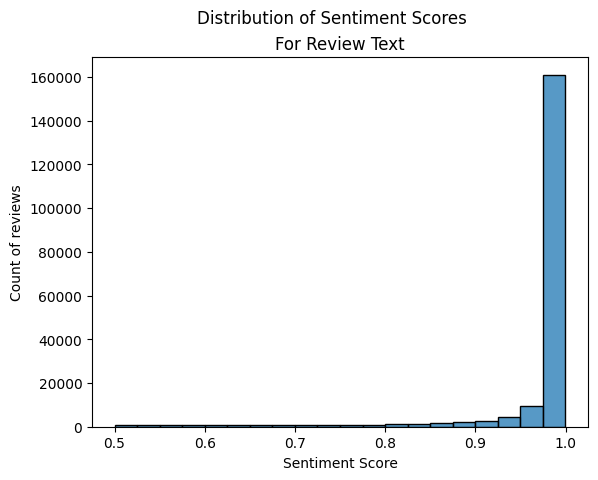

In [ ]:
# plot the distribution of sentiment scores
sns.histplot(data=df_runway,
            x="sentiment_score",
            bins=20
            )
plt.suptitle("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Count of reviews")
plt.title("For Review Text")
plt.show()

The distribution of sentiment scores for review text reveals that the majority of the customers are quite satisfied with their purchases. This suggests that the products generally meet or exceed customers expectstions, leading to positive overall sentiment. The few lower scores might highlight areas for imporovment.

In [ ]:
# New column called "year" for the year of the "review_date"
df_runway["year"] = df_runway["review_date"].dt.year

# Review counts by "year" and "sentiment_category"
review_counts = df_runway.groupby(["year", "sentiment_category"], as_index=False)["user_id"].count()
review_counts.columns = ["year", "sentiment_category", "count"]
review_counts.head()


,year,sentiment_category,count
0,2010,POSITIVE,1
1,2011,NEGATIVE,22
2,2011,POSITIVE,187
3,2012,NEGATIVE,520
4,2012,POSITIVE,2845


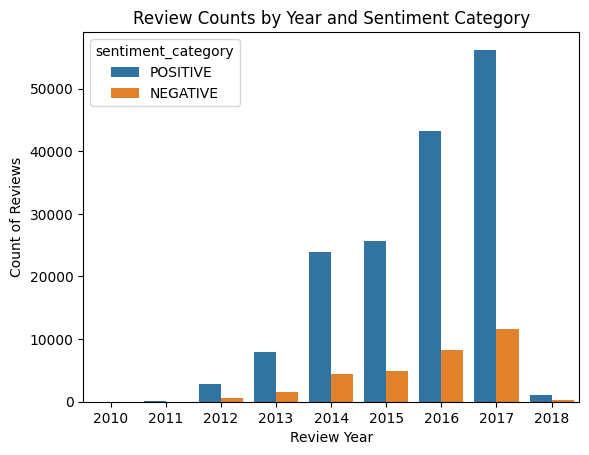

In [ ]:
# Plot the review count by "year" and "sentiment_category"
sns.barplot(data=review_counts,
            x="year",
            y="count",
            hue="sentiment_category",
            errorbar=None
            )
plt.title("Review Counts by Year and Sentiment Category")
plt.xlabel("Review Year")
plt.ylabel("Count of Reviews")
plt.show()

The review count by year and sentiment category reveals a steady increase in the number of reviews over the years, with both Positive and Negative reviews growing in volumes. However, Positive reviews consistently outnumber the Negative ones, indicating that despite the increase of users, the majority of the customers remain satisfied with their experiences.

# Embeddings

In [ ]:
# Model to be used in the embedding process
model_id = "sentence-transformers/all-MiniLM-L6-v2"

# instance to be used in the embedding process
model = SentenceTransformer(model_id)

# Generate the embeddings for the "rented for" column
embedding = model.encode(df_runway["rented for"])

In [ ]:
# Print the shape of the embedding
print(embedding.shape)

(192544, 384)


# Semantic Search

In [ ]:
# Define query
query = "a beautiful and impressive dress"

# Embed query
query_embedding = model.encode(query, convert_to_tensor=True)

# Calculate similarity between query and item embeddings
hits = semantic_search(query_embedding, embedding, top_k = 5)

for hit in hits[0]:
  idx = hit["corpus_id"]
  print(f"""
  ITEM ID: {df_runway.iloc[idx]["item_id"]}\n
  RENTED FOR: {df_runway.iloc[idx]["rented for"]}\n
  REVIEW: {df_runway.iloc[idx]["review_text"]}\n
  {800*"_"}""")



  ITEM ID: 616682

  RENTED FOR: wedding

  REVIEW: I have always been petite in my upper body and extremely athletic. 
I'm 5'9 and typically am a size 4,6,8 due to the fact I had a smaller upper frame and 34B cup. Depends what fabric were talking about too! 
However, because I have been lifting weights my back has grown (odd to add- but figured I'd say it knowing other people lift weights) My lat area is so wide that I was suffocating in a size 6. If I wasn't as muscular in my back I would've been fine. I would recommend to go up a size if you are into lifting weights and very broad in your upper body. 

  ________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

The results show the top 5 items that are semantically closest to the query "a beautiful and impressive dress" All five items were rented for weddings.

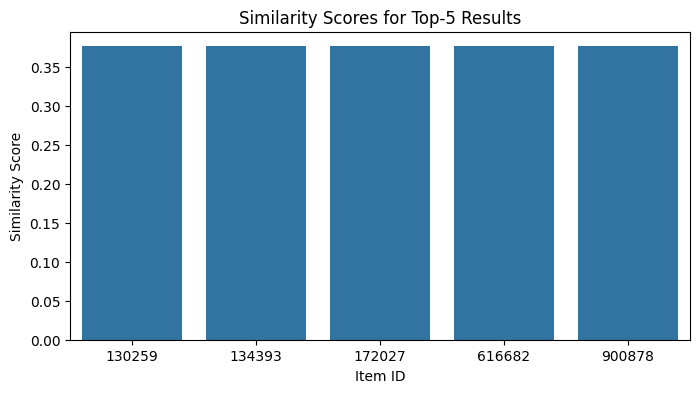

In [ ]:
# Extract similarity scores and item IDs
similarity_scores = [hit["score"] for hit in hits[0]]
item_ids = [df_runway.iloc[hit["corpus_id"]]["item_id"] for hit in hits[0]]

# Plot similarity scores of top-5 results
plt.figure(figsize=(8, 4))
sns.barplot(x=item_ids, y=similarity_scores)
plt.title("Similarity Scores for Top-5 Results")
plt.xlabel("Item ID")
plt.ylabel("Similarity Score")
plt.show()

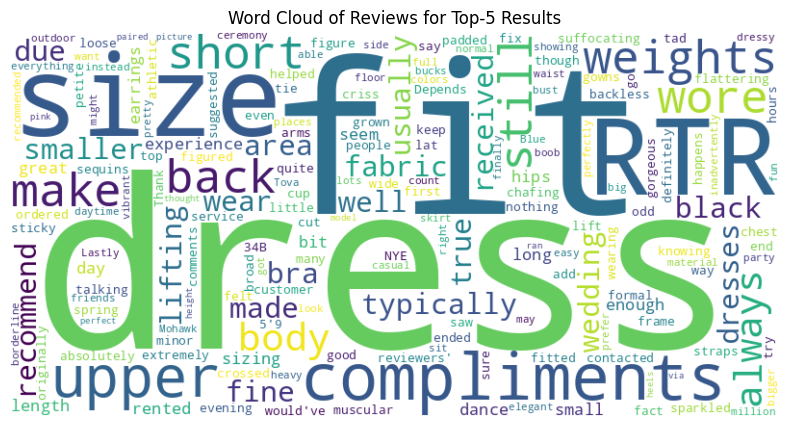

In [ ]:
# Combine reviews from top-5 results of semantic search with 'rented for' column
reviews = " ".join([df_runway.iloc[hit["corpus_id"]]["review_text"] for hit in hits[0]])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(reviews)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Reviews for Top-5 Results")
plt.show()

In [ ]:
# Create a DataFrame for top-5 results
results_df = pd.DataFrame({
    "Item ID": [df_runway.iloc[hit["corpus_id"]]["item_id"] for hit in hits[0]],
    "Rented For": [df_runway.iloc[hit["corpus_id"]]["rented for"] for hit in hits[0]],
    "Review": [df_runway.iloc[hit["corpus_id"]]["review_text"] for hit in hits[0]],
    "Similarity Score": [hit["score"] for hit in hits[0]]
})

# Create an interactive table
fig = px.bar(results_df, x="Item ID", y="Similarity Score", hover_data=["Rented For", "Review"], title="Top-5 Results")
fig.show()

# Text Generation

In [ ]:
# Model to be used in the text generation process
generator = pipeline(model="gpt2")

# Define the prompt for the text generation process
prompt = "New for Train in Style campaign, a stylish gym outfit that"

# Genrate text based on the prompt
output = generator(prompt, num_return_sequences = 1, return_full_text = False)

# Display the generated text
print(f"New Marketing Campaign: {prompt}{output[0]['generated_text']}")

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


New Marketing Campaign: New for Train in Style campaign, a stylish gym outfit that fits seamlessly into a minimalist wardrobe.


In [ ]:
# Define several prompts for the text generation
prompts = [
    "New for Train in Style campaign, a stylish gym outfit that",
    "Introducing our latest collection, perfect for yoga and meditation, featuring",
    "Get ready for summer with our new beachwear line, designed to"
]

# Generate text based on the prompts
for prompt in prompts:
    output = generator(prompt, num_return_sequences=1, return_full_text=False)
    print(f"New Marketing Campaign: {prompt}{output[0]['generated_text']}\n{500*'_'}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


New Marketing Campaign: New for Train in Style campaign, a stylish gym outfit that features sleek silhouette and a button closure that opens the door to the outside like a stylish spring button. Available now on your smartphone or tablet for $16.99.

This year's
____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


New Marketing Campaign: Introducing our latest collection, perfect for yoga and meditation, featuring:

A new look at the body and mind

A more relaxed atmosphere while doing it

A unique way to look at the body

Our original design, featuring
____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
New Marketing Campaign: Get ready for summer with our new beachwear line, designed to create a timeless look in style. In our new beachwear line, we've got clothes for every style — from beach trunks to surfboard boots to polka dots and sandals
__________

In [ ]:
# Sevral models to campare text generation
models = ["gpt2", "EleutherAI/gpt-neo-125M", "distilgpt2"]

# Define the prompt for the text generation process
prompt = "New for Train in Style campaign, a stylish gym outfit that"

# Genrate text based on the prompts for each model
for model_name in models:
    generator = pipeline("text-generation", model=model_name)
    output = generator(prompt, num_return_sequences=1, return_full_text=False)
    print(f"Model: {model_name}\nGenerated Text: {prompt}{output[0]['generated_text']}\n{500*'_'}")

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model: gpt2
Generated Text: New for Train in Style campaign, a stylish gym outfit that matches your mood with a stylish suit to stay fit. You won't feel like you're missing out on the latest fashion trends, but don't be shy to wear this stylish new version of
____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________


Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model: EleutherAI/gpt-neo-125M
Generated Text: New for Train in Style campaign, a stylish gym outfit that will make you feel like you’re in the gym.

The new campaign is a
____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________


Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model: distilgpt2
Generated Text: New for Train in Style campaign, a stylish gym outfit that incorporates gym and home decor for easy transition for low-income students and those looking towards fitness.



To become a trainee, or a child
To become a teacher

____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________


In [ ]:
# Create input widget
prompt_input = widgets.Textarea(
    placeholder="Enter your prompt...",
    description="Prompt:",
    layout={"width": "500px"}
)

# Create button widget
generate_button = widgets.Button(description="Generate Text")

# Output widget
output_widget = widgets.Output()

# Define button click event
def on_button_click(b):
    with output_widget:
        output_widget.clear_output()
        output = generator(prompt_input.value, num_return_sequences=1, return_full_text=False)
        print(f"Generated Text: {prompt_input.value}{output[0]['generated_text']}")

generate_button.on_click(on_button_click)

# Display widgets
display(prompt_input, generate_button, output_widget)

Textarea(value='', description='Prompt:', layout=Layout(width='500px'), placeholder='Enter your prompt...')

Button(description='Generate Text', style=ButtonStyle())

Output()